In [ ]:
import datasets
from transformers import pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from src.models.TRANSFORMER import TransformerClassifier
from src.models.LSTM import LSTMClassifier
from transformers import BertModel
from src.local_datasets.goemotions import GoEmotionsDataset
from src.local_datasets.yelp import YelpDataset
from torch.utils.data import DataLoader
from torch.nn import functional as F


# DATASETS 

In [ ]:
yelp_pytorch = YelpDataset(split="train")
yelp_dataloaders = torch.utils.data.DataLoader(yelp_pytorch, batch_size=len(yelp_pytorch), shuffle=False)
yelp_data = next(iter(yelp_dataloaders))


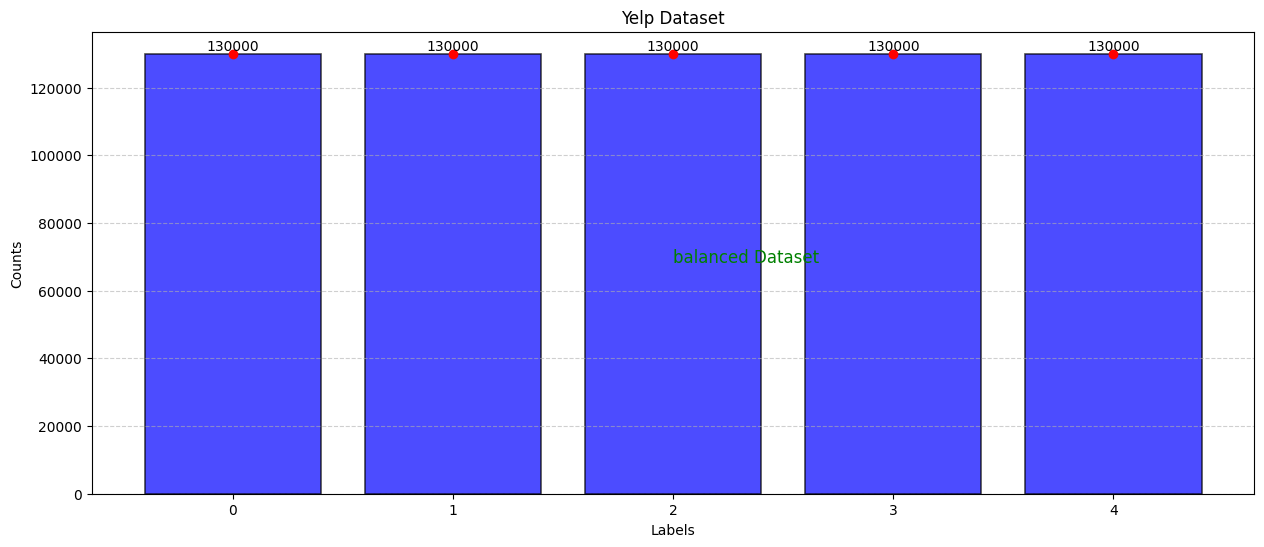

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import json


plt.figure(figsize=(15, 6))
_, labels,_ = yelp_data
label_counts = Counter(labels.numpy())
bars = plt.bar(label_counts.keys(), label_counts.values(),
        color='b',
        alpha=0.7,
        align='center',
        edgecolor='black',
        linewidth=1.2)

plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.annotate('balanced Dataset',
             xy=(0.5, 0.5), xytext=(0.5, 0.5), 
             textcoords='axes fraction', fontsize=12, 
             color='g')

plt.scatter(label_counts.keys(),
            label_counts.values(), 
            color='red')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{int(height)}', ha='center', va='bottom')

plt.title('Yelp Dataset')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(ticks=np.arange(5),)
plt.show()



In [ ]:
goemotions_pytorch = GoEmotionsDataset(split="train")
ge_dataloaders = torch.utils.data.DataLoader(goemotions_pytorch, batch_size=len(goemotions_pytorch), shuffle=False)
goemotions_data = next(iter(ge_dataloaders))


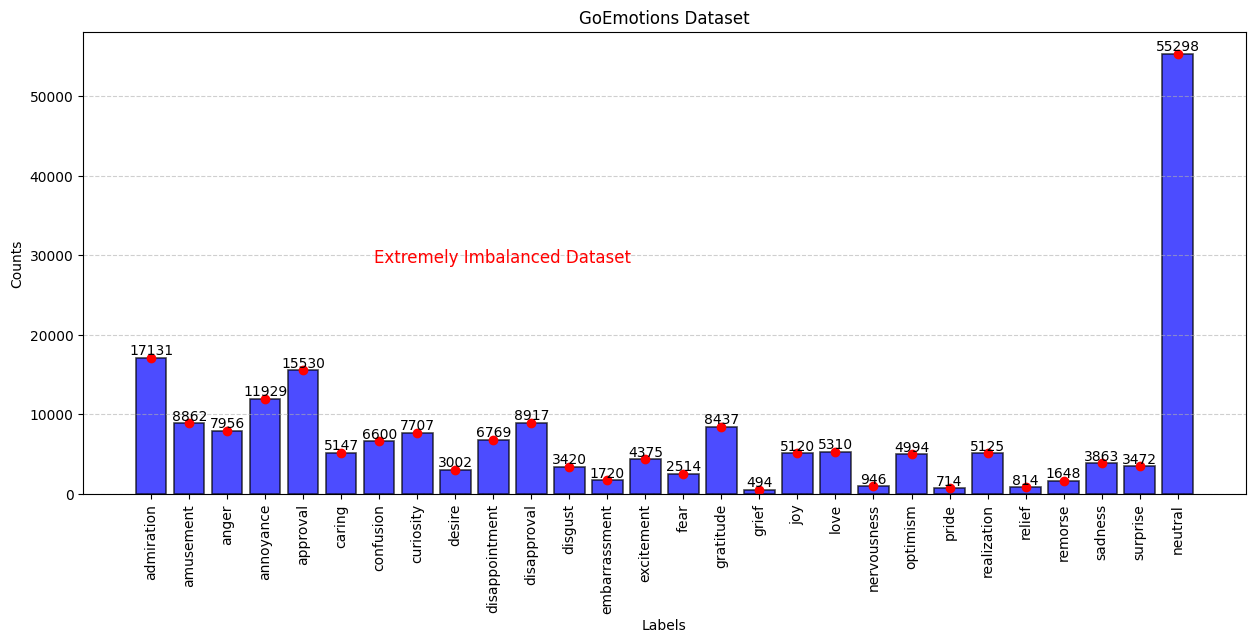

207814


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import json

with open('data/goemotions_labels.json') as f:
    label_names = json.load(f)['names']

_ , labels , _ = goemotions_data
label_counts = Counter(labels.numpy())

plt.figure(figsize=(15, 6))
bars = plt.bar(label_counts.keys(), label_counts.values(),
        color='b',
        alpha=0.7,
        align='center',
        edgecolor='black',
        linewidth=1.2)

plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.annotate('Extremely Imbalanced Dataset',
             xy=(0.5, 0.5), xytext=(0.25, 0.5), 
             textcoords='axes fraction', fontsize=12, 
             color='red')

plt.scatter(label_counts.keys(),
            label_counts.values(), 
            color='red')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{int(height)}', ha='center', va='bottom')

plt.title('GoEmotions Dataset')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(ticks=np.arange(len(label_names)), labels=label_names, rotation=90)
plt.show()
print(len(goemotions_pytorch))

#### Train Random Forest Classifier ON YELP

In [20]:
from src.models.RFC import  RandomForestClassifier
from src.utils.helpers import load_from_disk, create_splits

path = "data/yelp_to_emotions.json"
new_yelp = load_from_disk(path)
train_data, train_labels, test_data, test_labels = create_splits(new_yelp)
rfc = RandomForestClassifier(n_jobs=32)
rfc.fit(train_data, train_labels)
preds = rfc.predict(test_data)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:   50.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.3s finished


In [21]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.55      0.65      0.60      9816
           1       0.34      0.34      0.34      9856
           2       0.33      0.30      0.31      9849
           3       0.36      0.32      0.34      9871
           4       0.50      0.52      0.51      9760

    accuracy                           0.43     49152
   macro avg       0.42      0.43      0.42     49152
weighted avg       0.42      0.43      0.42     49152



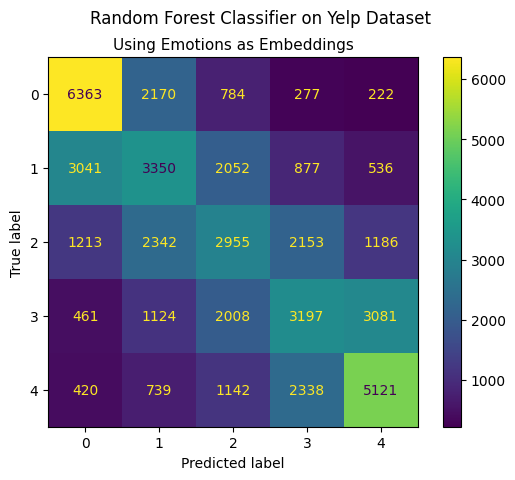

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.suptitle("Random Forest Classifier on Yelp Dataset", fontsize=12)
plt.title("Using Emotions as Embeddings", fontsize=11)
plt.show()

In [41]:
import json
with open('data/goemotions_labels.json') as f:
    Emotions_list = json.load(f)['names']

In [46]:
from src.local_datasets.yelp100 import Yelp100Dataset
yelp100k = Yelp100Dataset()

for idx, text, token, label in yelp100k:
    emotion_emd = test_data[idx]
    pred = rfc.predict(emotion_emd.reshape(1, -1))
    top2emotions = np.argsort(emotion_emd)[::-1][:3]
    print(top2emotions)
    print(f"Text: {text}\nLabel: {label}\nPrediction: {pred}\n\n ")
    print(f"Top 3 Emotions: {[Emotions_list[i] for i in top2emotions]}\n\n")

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


[ 0  9 27]
Text: I am giving Soba 5 stars for the experience I had there, even though I'm not quite sure the food deserves the whole 5 stars (Maybe 4.5)\nMy boyfriend and I came here for our anniversary. We are poor college students we got dressed up for our special dinner. We ordered several small plates: the Indonesian corn fritter wrap, the spicy tuna maki, the chicken and vegetable spring rolls, the korean barbecue ribs, and... something else! \nThe ribs were probably the best, and the corn fritter and tuna maki were also great. I was disappointed by the spring rolls - they were of good quality, but they were somewhat bland, and I expect a little more at a place (and a price!) like this. \nFor dessert we had the vanilla-poached peach with raspberry granita, coconut tapioca and brown sugar-barley crisps - this was fabulous! The combination of textures and flavors was superb. This appears to no longer be on the menu.\nThe real treat of the evening was the service we got from our wait

[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n

[18  3 27]
Text: If you like filthy buses, super high fares and about 50% rude operators then you will love Port Authority service.  Now if you like clean buses, reasonable fares and friendly service you will need to go somewhere else.  And no place for children as the language on the buses would make a sailor blush.  And in 14 years of riding Port Authority I have never seen a uniformed Port Authority officer riding a bus.
Label: 1
Prediction: [1]

 
Top 3 Emotions: ['love', 'annoyance', 'neutral']


[ 1 17  0]
Text: This is the fanciest library I've ever seen!  I haven't really been to many but compared to what this library used to look like before the expansion and compared to what I'm used to seeing back home, the Champaign Public Library is pretty cool.  \n\nMy favorite things about this library are:\n- Plenty of seating.  There are lots of open couches to sit on and read or tables to work on.  There are even quiet rooms if you need the extra silence.\n- The children's area.  I br

[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n

[14  0 27]
Text: I came here in October and ended up going on the \"Ghost Tales in the Dark\" tour. Pretty much, you get a candlelit tour of the plantation at night. And your tour guide gives a history lesson on the house and plantation, as well as shares some ghost stories that either they/coworkers have experienced.\n\nIf you come at night, it can be a little scary getting here. Once you turn off the main street, you're driving down a dark road with nature on both sides of you. Since we were already in a spooky spirit, it kind of felt like we were in a horror movie, hehe. Once you arrive at the plantation though, you just park and walk into their little gift shop. After everyone arrives, you watch a little video about the history of the place, including paranormal history. After that, your tour starts.\n\nYou walk over to the house, and tour the house, from downstairs to upstairs. Then, you walk outside to the outdoor kitchen, and then to a workmen's shed. Then you walk past an old l

[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n

[17  0 27]
Text: We've never been here when there is much life in this place, but i still kind of like it. Whenever we are there, it feels more like a hangout for a few folks to have a drink at the bar, but they have ample space to be a full-fledged restaurant. The most spacious, spread out dining area in Belmont it seems. i just need to go at a better time when there is a crowd here (assuming that time exist) to get a true feel for them. There are a few paintings on the wall that contrast the drab overall feel at night. \n\nWe have enjoyed their Chicken Jalapeno Dip twice now. Pretty tasty and pretty filling for two people. We split that with an entree and left full. \n\nTheir Facebook page said something about a new tv and game room, it must have been in the back because we were watching sports on an antique television over the bar. They did have $1 Budweiser cans when we were there and Southern Tier on draft. Seems to be something on special most days.
Label: 2
Prediction: [3]

 
To

[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n

[ 0 27  4]
Text: Great lunch spot. To repeat other reviews, the service is fast; probably the quickest I have ever experienced. As with most other locations I have visited, the staff is genuine and friendly.
Label: 3
Prediction: [4]

 
Top 3 Emotions: ['admiration', 'neutral', 'approval']


[ 9  3 27]
Text: Charlotte has grown I remember when the airport was small now it's like a little city of it's own. I don't mind waiting for a plane here as they have plenty of places to eat and pass time. They made it look real nice and \"purdee\" inside so you feel like you're in a nice place unlike Newark or JFK which are boring as hell to me. I don't think the majority of passengers will be disappointed passing through here.
Label: 3
Prediction: [1]

 
Top 3 Emotions: ['disappointment', 'annoyance', 'neutral']


[ 0 12  9]
Text: Ok so my first experience at princess nails could be described as slightly awkward but totally worth it. When I went into the salon I didn't realize how cramped it actua

[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n

[ 0  9 26]
Text: So our intentions were to eat at the Indian place across the street however a lady ran across the street and started rattling off the menu as we were walking. At first I liked her moxy, but soon realized that if this is how they need to bring in customers we may be in trouble. Another mistake was sitting outside when they are trying to bring people in. Our dinner conversation was constantly interrupted by the servers yelling across the street and on the side walk at potential customers. \n\nNow on to the food:\n\nI ordered the chicken kabob. Very bland and it actually tasted baked not grilled. I didn't finish it.  The rice was good and the side veggies weren't bad. The spinach pie was ok. \n\nThey will ask \"would you like hummus to snack on before your meal\". This is not free or included. I figured this so I wasn't caught off guard. Some people I could see will be surprised at the end when they get the bill. \n\nMy wife got the lamb kabob. Bland again and very chewy.

[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n

[ 0  3 17]
Text: I have been to this place plenty of times. I have always had good meals and service. But tonight was bad. I went ther with my wife's work friends. We sat at the bar tables and had a bartender named Bo(very red hair)   We had About 8 people and he insisted that if we sit at the tables we have to order food, which we had planned to do. He seemed annoyed with us because we just ordered fried oysters and lots of drinks(it was Friday and happy hour, so we were sitting around chatting and drinking)  we were actually going to order an entre and stay for dinner but Bo seemed very disinterested in us, until it came time to pay the bill, then he was really nice(tip time! Overall the food is good there, but Bo did not make it a pleasant experience. Smile Bo, it will get you far in life!
Label: 0
Prediction: [2]

 
Top 3 Emotions: ['admiration', 'annoyance', 'joy']


[27 10  3]
Text: I can't anymore. It's too busy here and service is not as fast as other Mickey D's with this kind 

[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n

[ 6 27  5]
Text: I went in for an oil change and an inspection. i receive close to a thousand dollars in \"recommendations.\" The next day, I decided to get the breaks serviced as they told me it was the most pressing issue with my car. After fixing my breaks they refused to put my tire on because they decided it was not road worthy, but for an additional 200 bucks they would fix it for me. \n\nPerhaps I would have been more understanding if :\n\n1) This had been in the original inspection (it wasn't) \n2) I hadn't had the tire looked at on several other occasions including them (twice! Once several months ago and once during inspection) \n3) They hadn't decided for me what is and is not acceptable - (ask first then together we make choice).\n4)They asked me to sign a new inspection ticket as if they had brought up wheels initially, smeared with capital letters and exclamations as if that would help send it back into the past. I found it so antagonizing that I decided to share the expe

[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
